In [1]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model
import torch
import numpy as np
import pickle

/home/awernersson/venvs/instadeep/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data & final params

In [2]:
# Load data
import pandas as pd

df_train = pd.read_csv('../data/promoter_200bp_train.csv')
df_test = pd.read_csv('../data/promoter_200bp_test.csv')

In [3]:
X_train = df_train['sequence'].tolist()
Y_train = df_train['label'].values

X_test = df_test['sequence'].tolist()
Y_test = df_test['label'].values


In [ ]:
with open('/gpfs/scratch1/shared/awernersson/nucleotide_results/outs_train_200bp_1000_testing33.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)

with open('/gpfs/scratch1/shared/awernersson/nucleotide_results/outs_test_200bp_1000_testing33.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)
    
with open('/gpfs/scratch1/shared/awernersson/nucleotide_results_test33/200_bp_classifier_params.pkl', 'rb') as f:
    final_params = pickle.load(f)

with open('/gpfs/scratch1/shared/awernersson/nucleotide_results_test33/200_bp_losses.pkl', 'rb') as f:
    loss_dict = pickle.load(f)

In [5]:
from Classifier import PromoterClassifier, PromoterClassifierNet

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rng = jax.random.PRNGKey(0)
model = hk.transform(PromoterClassifierNet)

# Step 2: Get predictions from YOUR classifier (using embeddings, not tokens!)
train_logits = model.apply(final_params, rng, train_embeddings, is_training=False)
test_logits = model.apply(final_params, rng, test_embeddings, is_training=False)

# Step 3: Convert logits to predictions
# For binary classification with shape [batch, 1]:
train_preds = (jax.nn.sigmoid(train_logits) > 0.5).astype(int).squeeze()
test_preds = (jax.nn.sigmoid(test_logits) > 0.5).astype(int).squeeze()

print(f"Train preds shape: {train_preds.shape}")
print(f"Test preds shape: {test_preds.shape}")

# Step 4: Calculate metrics
print("Train Accuracy : {:.3f}".format(accuracy_score(Y_train, train_preds)))
print("Test Accuracy : {:.3f}".format(accuracy_score(Y_test, test_preds)))

print("\nTest Classification Report:")
print(classification_report(Y_test, test_preds, target_names=['Non-Promoter', 'Promoter']))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, test_preds))

Train preds shape: (700,)
Test preds shape: (150,)
Train Accuracy : 0.947
Test Accuracy : 0.873

Test Classification Report:
              precision    recall  f1-score   support

Non-Promoter       0.81      0.92      0.86        65
    Promoter       0.93      0.84      0.88        85

    accuracy                           0.87       150
   macro avg       0.87      0.88      0.87       150
weighted avg       0.88      0.87      0.87       150


Confusion Matrix:
[[60  5]
 [14 71]]


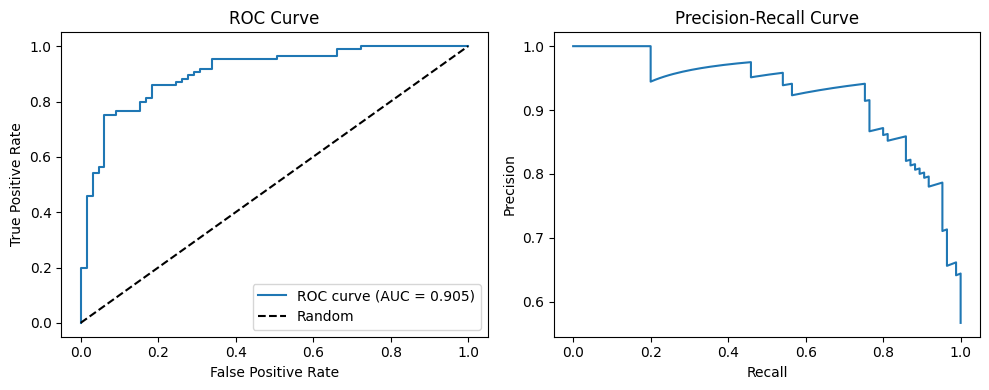

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, jax.nn.sigmoid(test_logits).squeeze())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, jax.nn.sigmoid(test_logits).squeeze())
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

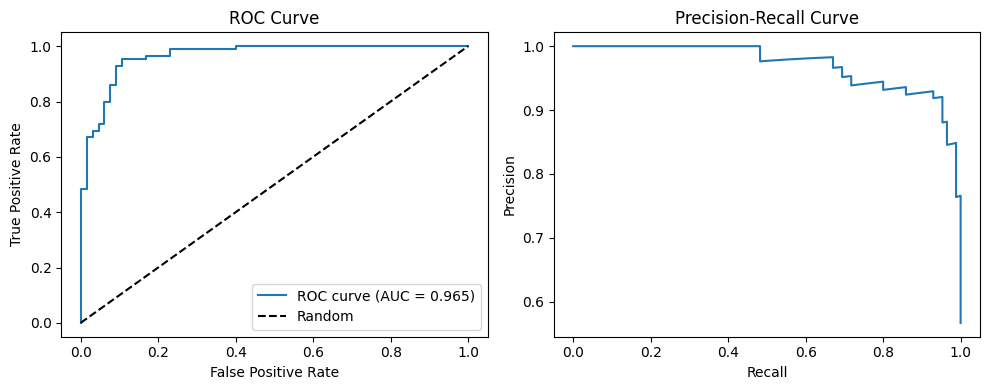

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, jax.nn.sigmoid(test_logits).squeeze())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, jax.nn.sigmoid(test_logits).squeeze())
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

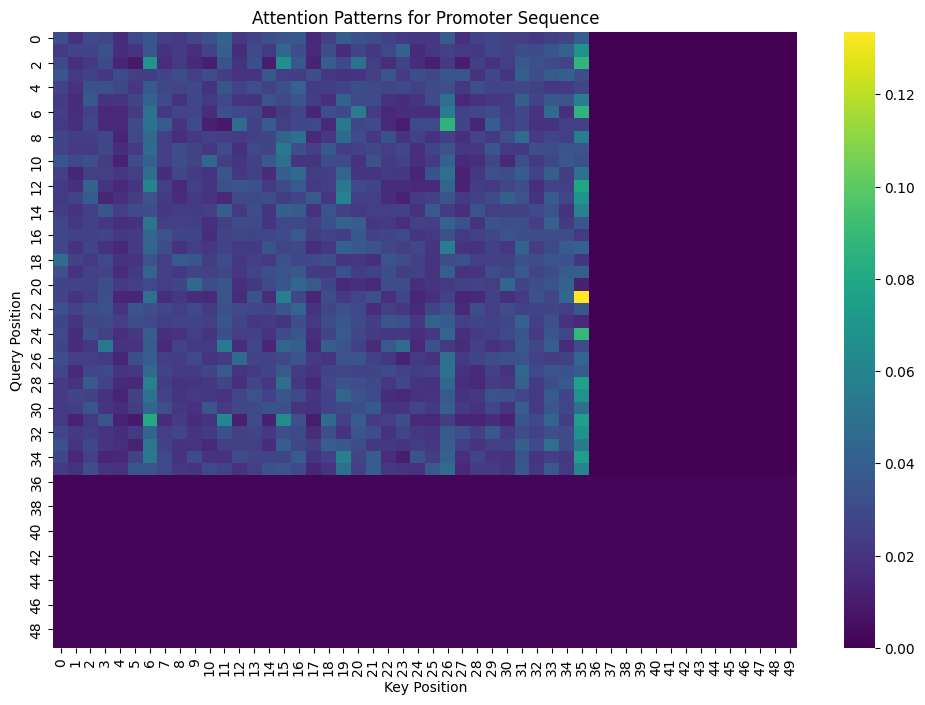

In [ ]:
# You saved attention maps! Use them:
# attention_maps_to_save=((1, 4), (7, 16))

import seaborn as sns

# Get attention for a promoter sequence
seq_id = 0  # Pick an interesting sequence
attention = outs["attention_map_layer_1_number_4"][seq_id]  # Layer 1, head 4

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(attention[:50, :50], cmap='viridis', cbar=True)
plt.title('Attention Patterns for Promoter Sequence')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()